# Investigating Ranks
In the first section, I am going to investigate what an appropriate rank to consider should be. It will make sense to look at the 
ranks of a trained matrix and a randomly initialized matrix. We will start by looking at a randomly initialized matrix and then
look at a trained matrix. Specifically, I will look at the rank of a randomly initialized matrix. I will need to consider the sizes 
that are seen in RoBERTa

## Imports and Helper Functions

In [1]:
# Import Appropriate Libraries
%load_ext autoreload
    
import torch
import matplotlib.pyplot as plt 
import bisect
import sys
sys.path.append("../")

# Set Logging Level
import logging
level = logging.DEBUG
logging.getLogger("requests").setLevel(level)
logging.getLogger("urllib3").setLevel(level)

In [2]:
def get_principle_direction(A, exp_var):
    U, S, V = torch.linalg.svd(A)
    X = (torch.cumsum(S, 0) / S.sum().item()).tolist()
    num = bisect.bisect(X, exp_var)
    return num

## Normally Initialized Matrix Analysis

In [3]:
def plot_results(n=100, size=[768, 768], exp_var=0.99):
    results = []
    for _ in range(n):
        A = torch.randn(size)
        num = get_principle_direction(A, exp_var)
        results.append(num)
    return results

(array([51.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 49.]),
 array([515. , 515.1, 515.2, 515.3, 515.4, 515.5, 515.6, 515.7, 515.8,
        515.9, 516. ]),
 <BarContainer object of 10 artists>)

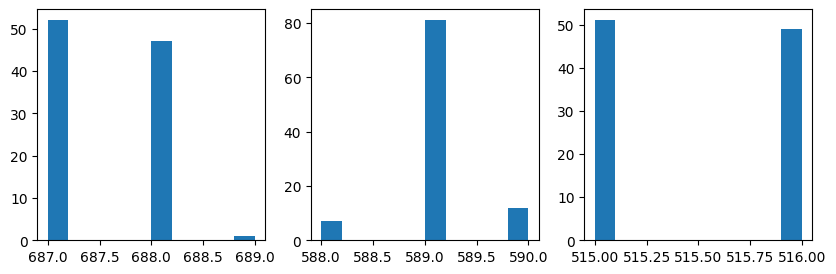

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))
ax[0].hist(plot_results())
ax[1].hist(plot_results(exp_var=0.95))
ax[2].hist(plot_results(exp_var=0.9))

The above results indicate the rank is very tightly distributed based on the explained variance. The reader is encouraged to play with the explained_variance and support the claim themselves.

## Analysis of RoBERTa pre-trained Weights 

In [4]:
## Now let's look at how tightly the weights are distributed in RoBERTa 
from transformers import AutoModel, AutoConfig

In [5]:
# Extract RoBERTa Configuration
roberta_base_config = AutoConfig.from_pretrained('roberta-base')
roberta_large_config = AutoConfig.from_pretrained('roberta-large')

In [6]:
# Extract RoBERTa Model
roberta_base_model = AutoModel.from_config(roberta_base_config)
roberta_large_model = AutoModel.from_config(roberta_large_config)

In [7]:
def print_principle_direction(model, exp_var):
    for key, param in model.named_parameters():
        with torch.no_grad():
            key = ".".join(key.split(".")[3:])
            p_size = min(param.size())
            if len(param.size()) < 2:
                continue
            print(key, get_principle_direction(param, exp_var), p_size)

In [13]:
explained_variance = 0.99
print("# Roberta Base Principle Directions \n")
print_principle_direction(roberta_base_model, explained_variance)

print("\n# Roberta Large Principle Directions \n")
print_principle_direction(roberta_large_model, explained_variance)

# Roberta Base Principle Directions 

 759 768
 492 514
 0 1
attention.self.query.weight 687 768
attention.self.key.weight 687 768
attention.self.value.weight 687 768
attention.output.dense.weight 687 768
intermediate.dense.weight 753 768
output.dense.weight 753 768
attention.self.query.weight 688 768
attention.self.key.weight 687 768
attention.self.value.weight 687 768
attention.output.dense.weight 688 768
intermediate.dense.weight 753 768
output.dense.weight 753 768
attention.self.query.weight 688 768
attention.self.key.weight 688 768
attention.self.value.weight 687 768
attention.output.dense.weight 688 768
intermediate.dense.weight 753 768
output.dense.weight 753 768
attention.self.query.weight 688 768
attention.self.key.weight 688 768
attention.self.value.weight 687 768
attention.output.dense.weight 687 768
intermediate.dense.weight 753 768
output.dense.weight 753 768
attention.self.query.weight 687 768
attention.self.key.weight 688 768
attention.self.value.weight 687 768
attention

On the surface, the above results suggest you need most of the directions to account for the explained variance in the parameters.
As such, we finetune the models for SQuAD and review the difference in the weights of the base and the tuned model. If the difference has 
fewer principle directions with high explanation, it would mean it is possible the task-based fine-tuning can be done in a smaller subspace. 

## Rank Variation During Training

In [14]:
# Get Dataset
import hydra
from omegaconf import DictConfig, OmegaConf
from datasets import load_dataset
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from train.train import train_epoch
from utils.metrics import AverageMeter

In [15]:
# Extract Training Configuration
with hydra.initialize(version_base=None, config_path="../config"):
    cfg = hydra.compose(config_name="app_config")

### Data Analysis

In [29]:
# Process Data
train_dataset = load_dataset("squad", split="train")
val_dataset = load_dataset("squad", split="validation")

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(cfg.model.name)

In [36]:
print(f"Model Max Length is {tokenizer.model_max_length}")
print(f"Dataset Features are {train_dataset.features}")

Model Max Length is 512
Dataset Features are {'id': Value(dtype='string', id=None), 'title': Value(dtype='string', id=None), 'context': Value(dtype='string', id=None), 'question': Value(dtype='string', id=None), 'answers': Sequence(feature={'text': Value(dtype='string', id=None), 'answer_start': Value(dtype='int32', id=None)}, length=-1, id=None)}


In [41]:
cut_off_length = 512
long_dataset = train_dataset.filter(lambda x: len(tokenizer(x['question'], x['context']).input_ids) > cut_off_length)
print(f"There are {long_dataset.num_rows} training instances with length longer than {cut_off_length}")

There are 143 training instances with length longer than 512


Since there are only 143 instances with the length longer than 512. I will remove those instances for the purpose of simplicity. These changes are unlikely to affect the outcome. The learned concept will not account for
the cases in which the context may not contain the answer. Also, if there is a regularity in the placement of the answer in the question, the model may over fit to it. But given large number of samples, I assume it is not
the case.

In [76]:
train_dataset = train_dataset.filter(lambda x: len(tokenizer(x['question'], x['context']).input_ids) <= cut_off_length)

In [80]:
## Let's See how the answer looks like
idx = 1
instance = train_dataset[idx]
answer = instance['answers']
print(answer['answer_start'][0])
print(answer['text'])
print(instance['context'][answer['answer_start'][0]:])

188
['a copper statue of Christ']
a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.


In [92]:
# The above indicates the answer_start is the beginning character. Let's see if this is consistent with the rest of the results
char_tokenizer = True
for idx, item in enumerate(train_dataset):
    start = item['answers']['answer_start'][0]
    end = start + len(item['answers']['text'][0])
    extracted_answer = item['context'][start:end]
    answer = item['answers']['text'][0]
    if extracted_answer != answer:
        print(idx, extracted_answer, answer)
    if char_tokenizer:
        tokenized_answer = tokenizer(answer).input_ids
        char_tokenizer = len(tokenized_answer) - 2 == len(answer)

if not char_tokenizer:
    print("Tokenizer is not character based")

Tokenizer is not character based


The above result confirms that the answers are made available in terms of character offset instead of tokenizer offset. This is likely the case to maintain generality. 

### Data Preparation

In [17]:
## Create Training Artifacts
training_cfg = hydra.utils.instantiate(cfg.model.model.train)

train_loader = DataLoader(train_dataset, batch_size=training_cfg.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=training_cfg.batch_size)

model = roberta_base_model
optimizer = AdamW(params=model.parameters(), lr=training_cfg.lr, weight_decay=training_cfg.weight_decay)
criterion = CrossEntropyLoss()

loss_meter = AverageMeter()
acc_meter = AverageMeter()

In [18]:
for item in train_dataset:
    x = f"[CLS]{item['question']}[SEP]{item['context']}"
    tokenized_x = tokenizer(item['question'], item['context'])
    print(tokenized_x)
    break

{'input_ids': [0, 3972, 2661, 222, 5, 9880, 2708, 2346, 2082, 11, 504, 4432, 11, 226, 2126, 10067, 1470, 116, 2, 2, 37848, 37471, 28108, 6, 5, 334, 34, 10, 4019, 2048, 4, 497, 1517, 5, 4326, 6919, 18, 1637, 31346, 16, 10, 9030, 9577, 9, 5, 9880, 2708, 4, 29261, 11, 760, 9, 5, 4326, 6919, 8, 2114, 24, 6, 16, 10, 7621, 9577, 9, 4845, 19, 3701, 62, 33161, 19, 5, 7875, 22, 39043, 1459, 1614, 1464, 13292, 4977, 845, 4130, 7, 5, 4326, 6919, 16, 5, 26429, 2426, 9, 5, 25095, 6924, 4, 29261, 639, 5, 32394, 2426, 16, 5, 7461, 26187, 6, 10, 19035, 317, 9, 9621, 8, 12456, 4, 85, 16, 10, 24633, 9, 5, 11491, 26187, 23, 226, 2126, 10067, 6, 1470, 147, 5, 9880, 2708, 2851, 13735, 352, 1382, 7, 6130, 6552, 625, 3398, 208, 22895, 853, 1827, 11, 504, 4432, 4, 497, 5, 253, 9, 5, 1049, 1305, 36, 463, 11, 10, 2228, 516, 14, 15230, 149, 155, 19638, 8, 5, 2610, 25336, 238, 16, 10, 2007, 6, 2297, 7326, 9577, 9, 2708, 4, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [19]:
for item in train_loader:
    print(item.keys())
    
    # print(item['question'])
    # print(item['context'])
    # print(item['answers']['answer_start'])
    tokenized_x = tokenizer(item['question'], item['context'])
    print(tokenized_x)
    break

dict_keys(['id', 'title', 'context', 'question', 'answers'])
{'input_ids': [[0, 1121, 99, 97, 1907, 9, 1304, 16, 44018, 67, 5850, 116, 2, 2, 133, 3710, 717, 36, 25674, 1785, 9, 16021, 3061, 43, 9, 666, 6, 552, 19, 484, 97, 194, 1265, 6904, 6, 34, 156, 44018, 41, 3626, 1973, 7, 5, 194, 18, 308, 781, 2777, 25, 10, 200, 50, 371, 2777, 2031, 11, 5, 1304, 24, 37138, 4, 96, 215, 1304, 6, 2239, 44018, 16, 41, 1973, 13, 11165, 195, 7, 290, 36, 21527, 293, 468, 7, 35959, 322, 152, 16, 1528, 9, 144, 1304, 13778, 19, 5, 8242, 3388, 792, 6, 941, 11, 167, 982, 147, 5, 781, 2777, 16, 19840, 4, 44018, 16, 67, 5850, 11, 2065, 821, 710, 1350, 38215, 1328, 666, 4, 2], [0, 1779, 21, 5, 13097, 3853, 7774, 8759, 1419, 116, 2, 2, 133, 5767, 338, 859, 8759, 11, 902, 8, 5, 13097, 3853, 7774, 8759, 11, 587, 3010, 373, 13, 10, 35898, 9, 30519, 6, 5, 741, 4061, 2577, 9, 24064, 4794, 5464, 8, 49, 7465, 19, 274, 27920, 6, 5, 22211, 9, 559, 9545, 6, 7465, 9, 24064, 4794, 88, 168, 6, 41, 23306, 13, 5, 121, 597, 1064

In [ ]:
logits = model.forward

# Introducing LoRA Weights
This section introduces LoRA weights in our models for further analysis.

In [3]:
# On the surface the above results suggest you need most of the directions to account for most of the directions. 
# It will be useful to see which directions are affected and how later.
from models.LoRA import LoRALinearLayer
def add_linear_lora(module, rank, init_type=0):
    for key, child in module.named_children():
        if isinstance(child, torch.nn.Linear):
            lora_layer =  LoRALinearLayer(child, rank=rank, init_type=init_type)
            setattr(module, key, lora_layer)
        else:
            add_linear_lora(child, rank, init_type)

In [4]:
add_linear_lora(roberta_base, rank=10, init_type=1)

In [5]:
roberta_base

RobertaHubInterface(
  (model): RobertaModel(
    (encoder): RobertaEncoder(
      (sentence_encoder): TransformerEncoder(
        (dropout_module): FairseqDropout()
        (embed_tokens): Embedding(50265, 768, padding_idx=1)
        (embed_positions): LearnedPositionalEmbedding(514, 768, padding_idx=1)
        (layernorm_embedding): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (layers): ModuleList(
          (0-11): 12 x TransformerEncoderLayerBase(
            (self_attn): MultiheadAttention(
              (dropout_module): FairseqDropout()
              (k_proj): LoRALinear(in_features=768, in_features=768, rank=$10, init_type=$1)
              (v_proj): LoRALinear(in_features=768, in_features=768, rank=$10, init_type=$1)
              (q_proj): LoRALinear(in_features=768, in_features=768, rank=$10, init_type=$1)
              (out_proj): LoRALinear(in_features=768, in_features=768, rank=$10, init_type=$1)
            )
            (self_attn_layer_norm): LayerNorm

In [6]:
roberta_large

RobertaHubInterface(
  (model): RobertaModel(
    (encoder): RobertaEncoder(
      (sentence_encoder): TransformerEncoder(
        (dropout_module): FairseqDropout()
        (embed_tokens): Embedding(50265, 1024, padding_idx=1)
        (embed_positions): LearnedPositionalEmbedding(514, 1024, padding_idx=1)
        (layernorm_embedding): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (layers): ModuleList(
          (0-23): 24 x TransformerEncoderLayerBase(
            (self_attn): MultiheadAttention(
              (dropout_module): FairseqDropout()
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
       

In [47]:
from transformers import AutoTokenizer, AutoModel, AutoConfig

In [48]:
model_config = AutoConfig.from_pretrained('roberta-base')

DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/1.1" 200 0


In [49]:
model = AutoModel.from_config(model_config)